# **import packages**

In [1]:
import numpy as np
import sklearn
from sklearn.svm import SVC, LinearSVC, LinearSVR, SVR
from sklearn.linear_model import SGDClassifier
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.metrics import mean_squared_error

In [2]:
# configure the font sizes of the figure
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick',labelsize=10)
plt.rc('ytick', labelsize=10)

**(9) Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.**

In [3]:
data = datasets.load_iris(as_frame=True)

In [4]:
X = data.data[["petal length (cm)", "petal width (cm)"]].values
y = data.target
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [5]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

In [6]:
LinSvc_clf = LinearSVC(loss='hinge', C=1, dual=True, random_state=42)
Svc_clf = SVC(C=1, kernel='linear',random_state=42)
Sgd_clf = SGDClassifier(alpha=0.01, random_state=42)

In [7]:
LinSvc_clf.fit(x_scaled, y)
Svc_clf.fit(x_scaled, y)
Sgd_clf.fit(x_scaled, y)

SGDClassifier(alpha=0.01, random_state=42)

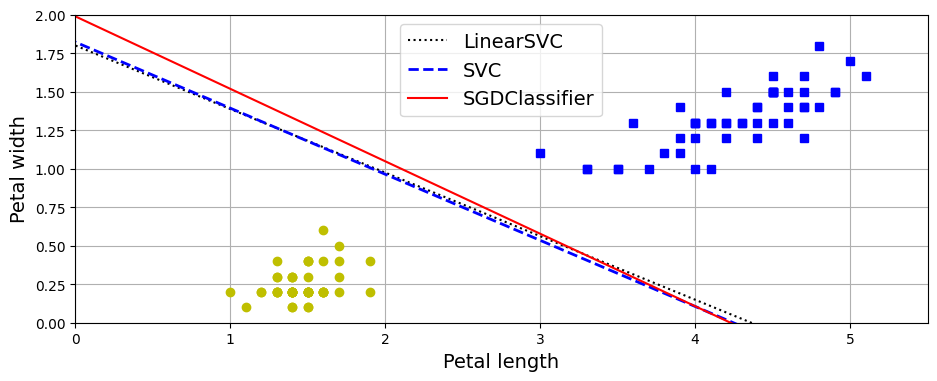

In [8]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(LinSvc_clf)
svc_line = compute_decision_boundary(Svc_clf)
sgd_line = compute_decision_boundary(Sgd_clf)

plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()
plt.show()

**(10) Train an SVM classifier on the wine dataset, which you can load using sklearn.datasets.load_wine(). This dataset contains the chemical analyses of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine’s chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all three classes. What accuracy can you reach?**

In [9]:
wine_data = datasets.load_wine(as_frame = True)

In [10]:
# test size = 0.25 (as default)
X_train, X_test, y_train, y_test = train_test_split(wine_data.data, wine_data.target, random_state=42)
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [11]:
# It will automatically use the One-vs-All
lin_clf = LinearSVC(dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

In [12]:
LinearSVC_clf = make_pipeline(StandardScaler(),
                        LinearSVC(dual=True, random_state=42))
LinearSVC_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

In [13]:
# showing the performance of 'LinearSVC' using cross validation
cross_val_score(LinearSVC_clf, X_train, y_train).mean()

0.9774928774928775

**Trying use SVC**

In [14]:
SVC_clf = make_pipeline(StandardScaler(),
                        SVC(random_state=42))
SVC_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [15]:
cross_val_score(SVC_clf, X_train, y_train).mean()

0.9698005698005698

Make some parameter tuning

In [16]:
param_distributions = {'svc__gamma':loguniform(0.001, 0.1),
                      'svc__C': uniform(1, 10)}
rnd_search = RandomizedSearchCV(SVC_clf, param_distributions, n_iter =100,
                                cv = 5, random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(random_state=42))]),
                   n_iter=100,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x782945ddab90>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x782945dda6e0>},
                   random_state=42)

In [17]:
rnd_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=9.925589984899778, gamma=0.011986281799901188,
                     random_state=42))])

In [18]:
rnd_search.best_score_

0.9925925925925926

The result on test data

In [19]:
rnd_search.score(X_test, y_test)

0.9777777777777777

**(11) Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2, which you can load using sklearn.datasets.fetch_california_housing(). The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use far fewer instances (e.g., 2,000) to test many more hyperparameter combinations. What is your best model’s RMSE?**

In [20]:
housing_data = datasets.fetch_california_housing()
print(housing_data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [21]:
X = housing_data.data
y = housing_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [22]:
linearSVR_clf = make_pipeline(StandardScaler(), LinearSVR(random_state=True))
linearSVR_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(random_state=True))])

failed to converge

In [23]:
linearSVR_clf = make_pipeline(StandardScaler(),LinearSVR(max_iter=10000, dual=True, random_state=42))
linearSVR_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(max_iter=10000, random_state=42))])

In [24]:
y_pred  = linearSVR_clf.predict(X_train)
MSE  =  mean_squared_error(y_train, y_pred)
np.sqrt(MSE)

0.979565447829459

In [25]:
y_pred = linearSVR_clf.predict(X_test)
MSE  =  mean_squared_error(y_test, y_pred)
np.sqrt(MSE)

0.7659274332664302

In [26]:
X_train_tun = X_train[:2000]
y_train_tun = y_train[:2000]

In [27]:
svm_reg = make_pipeline(StandardScaler(), SVR())
param_distrib = {"svr__gamma": loguniform(0.001, 0.1),
                 "svr__C": uniform(1, 10)}

rnd_search_cv = RandomizedSearchCV(svm_reg, param_distrib, n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train_tun, y_train_tun)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78294489ef80>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x782945e2dc00>},
                   random_state=42)

In [28]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=4.63629602379294, gamma=0.08781408196485979))])

In [29]:
rnd_search_cv.best_score_

0.7572774474774365

In [30]:
-cross_val_score(rnd_search_cv.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

In [31]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.5854732265172238